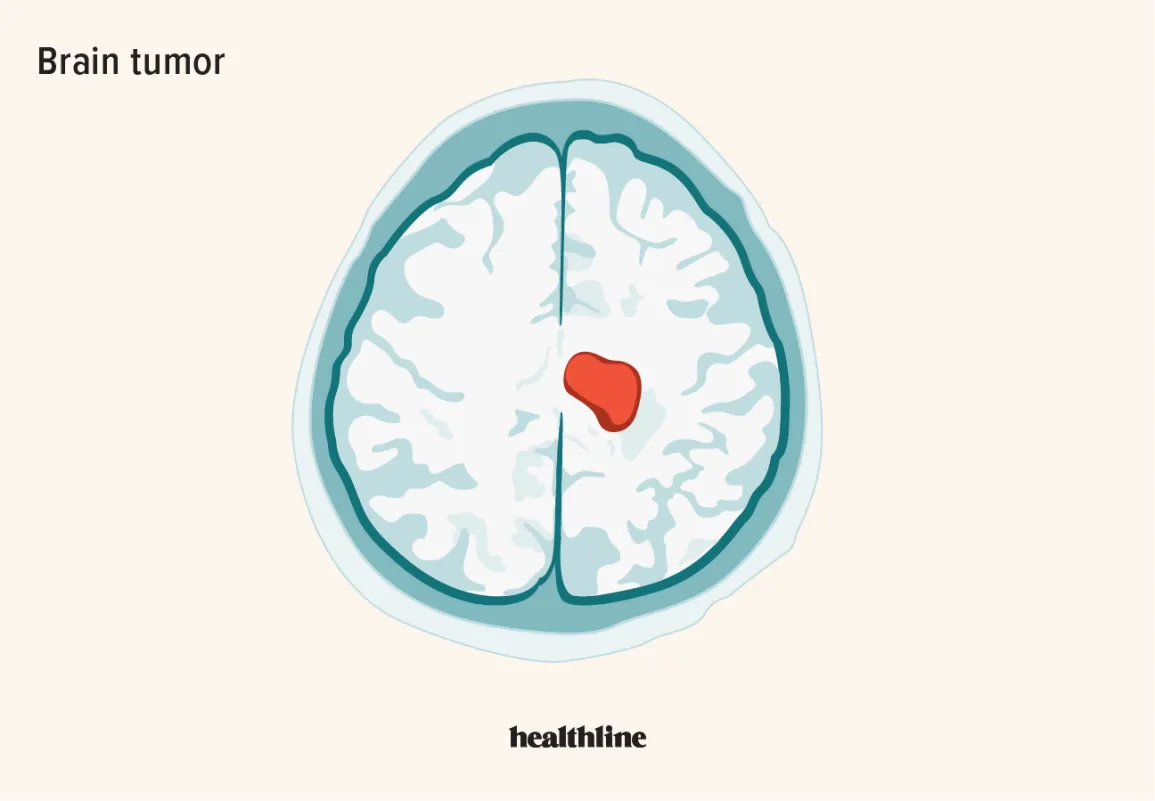

<B span style="color: red; font-size: 30px;" >Import Libraries</span>

In [18]:
import splitfolders
from skimage import io
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<B span style="color: red; font-size: 30px;" >Split Data into train, validation and test</span>

In [1]:
Data='D:/download 3/archive (6)/brain_tumor_dataset/'
data_devided ='D:/download 3/archive (6)/Data Devided/'
splitfolders.ratio(Data,data_devided, seed=1337,ratio=(0.7,0.2,.1) )

Copying files: 1586 files [00:17, 91.67 files/s] 


In [3]:
train_loc = 'D:/download 3/archive (6)/Data Devided/train/'
test_loc='D:/download 3/archive (6)/Data Devided/test/'
val_loc='D:/download 3/archive (6)/Data Devided/val/'

<B span style="color: red; font-size: 30px;" >Image Processing</span>

In [4]:
RANDOM_SEED = 123
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    
    rescale= 1./255
    
)

train_generator = train_datagen.flow_from_directory(
    train_loc,
    color_mode='rgb',
  
    batch_size=64,
    class_mode='binary',
    seed=RANDOM_SEED,
   target_size= (128,128)
)
valid_datagen = ImageDataGenerator(
    
    rescale= 1./255
    
)

validation_generator = valid_datagen.flow_from_directory(
    val_loc,
    color_mode='rgb',
    batch_size=64,
    class_mode='binary',
    seed=RANDOM_SEED,
    shuffle=False,
    target_size= (128,128)
)
test_datagen = ImageDataGenerator(
    
    rescale= 1./255
)
test_generator=test_datagen.flow_from_directory(
     test_loc,
    color_mode='rgb',
    class_mode='binary',
    seed=RANDOM_SEED,
    shuffle=False,
    target_size= (128,128)
)
    

Found 1268 images belonging to 2 classes.
Found 633 images belonging to 2 classes.
Found 161 images belonging to 2 classes.


<B span style="color: red; font-size: 30px;" >Encoding Target</span>

In [5]:
train_generator .class_indices

{'no_tumor': 0, 'tumor': 1}

<B span style="color: red; font-size: 30px;" >Plot Images</span>

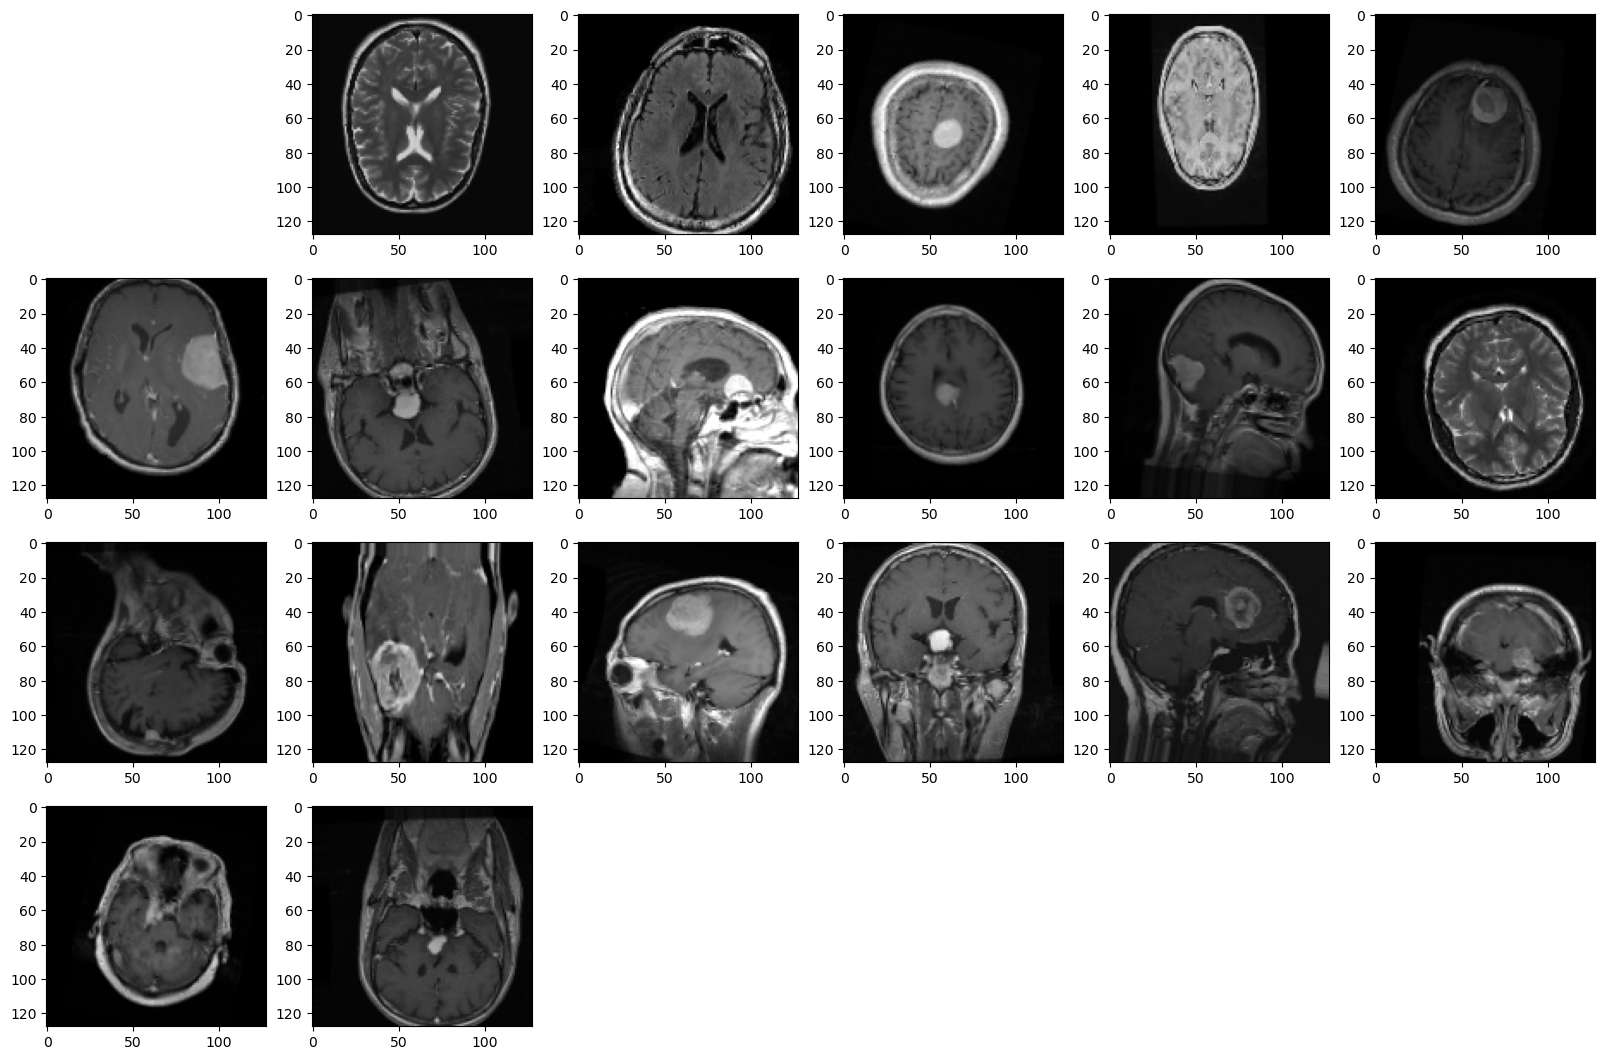

In [6]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
   
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

<B span style="color: red; font-size: 30px;" >Used Transfer learning model (VGG16) and add some hidden layers</span>

In [57]:
base_model=VGG16(include_top=False,weights='imagenet',input_shape=(128,128,3))

In [58]:
base_model.trainable=False

In [59]:
model = keras.Sequential([
    
    
    base_model, #vgg16
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [61]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [73]:
history=model.fit(train_generator, epochs=10, validation_data=validation_generator)    

Epoch 1/10
20/20 [==============================] - 81s 4s/step - loss: 0.2621 - accuracy: 0.8841 - val_loss: 0.2237 - val_accuracy: 0.9084
Epoch 2/10
20/20 [==============================] - 88s 4s/step - loss: 0.2445 - accuracy: 0.8943 - val_loss: 0.2164 - val_accuracy: 0.9163
Epoch 3/10
20/20 [==============================] - 86s 4s/step - loss: 0.2263 - accuracy: 0.8991 - val_loss: 0.2588 - val_accuracy: 0.9005
Epoch 4/10
20/20 [==============================] - 85s 4s/step - loss: 0.2359 - accuracy: 0.9022 - val_loss: 0.2077 - val_accuracy: 0.9194
Epoch 5/10
20/20 [==============================] - 87s 4s/step - loss: 0.2310 - accuracy: 0.9093 - val_loss: 0.2011 - val_accuracy: 0.9115
Epoch 6/10
20/20 [==============================] - 91s 5s/step - loss: 0.2406 - accuracy: 0.8951 - val_loss: 0.2728 - val_accuracy: 0.8863
Epoch 7/10
20/20 [==============================] - 87s 4s/step - loss: 0.2362 - accuracy: 0.8991 - val_loss: 0.2367 - val_accuracy: 0.9084
Epoch 8/10
20/20 [==

<B span style="color: red; font-size: 30px;" >Evaluate Model</span>

In [74]:
Model_evaluation = model.evaluate(validation_generator)
print(f"Loss: {Model_evaluation[0]*100:.2f} %\nAccuracy: {Model_evaluation[1]:.4f} %")

10/10 [==============================] - 27s 3s/step - loss: 0.1937 - accuracy: 0.9273
Loss: 19.37 %
Accuracy: 0.9273 %


<B span style="color: red; font-size: 30px;" >Save Model</span>

In [75]:
tf.keras.models.save_model(model,'model.h5')

In [76]:
predictions = model.predict(validation_generator)

10/10 [==============================] - 27s 3s/step


<B span style="color: red; font-size: 30px;" >Plot History</span>

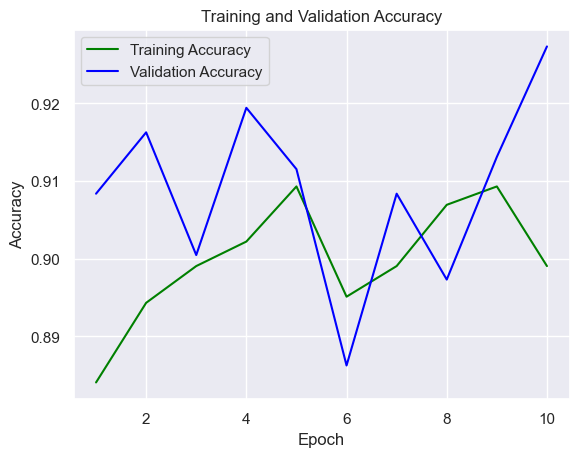

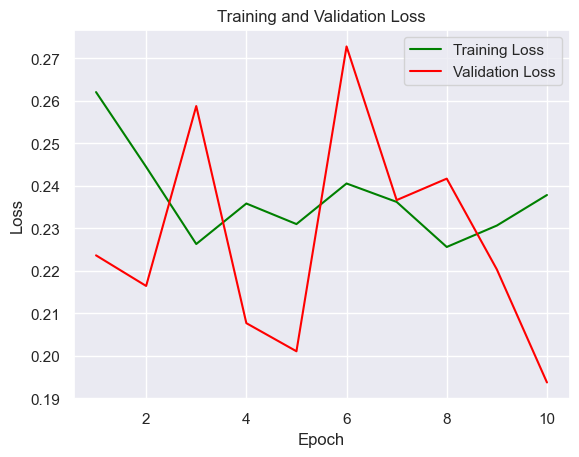

In [77]:
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

<AxesSubplot:>

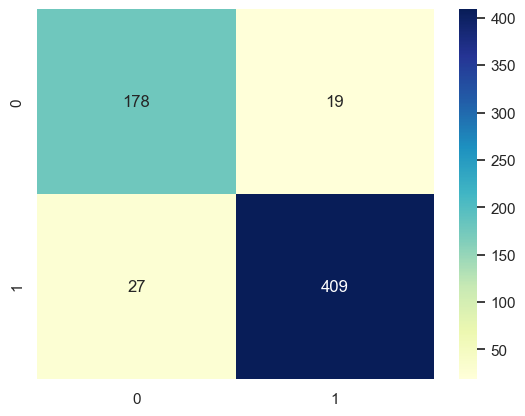

In [78]:
cm = confusion_matrix(validation_generator.classes, predictions.round())
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [79]:
from sklearn.metrics import classification_report
print(classification_report(validation_generator.classes, predictions.round()))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       197
           1       0.96      0.94      0.95       436

    accuracy                           0.93       633
   macro avg       0.91      0.92      0.92       633
weighted avg       0.93      0.93      0.93       633



<B span style="color: red; font-size: 30px;" >Our Mision is To Reduce False Negative(FN) To make Recall high</span>

In [5]:
recall_1 = 409/(409+27)
recall_0 = 178/(178+19)
precision_1 = 409/(409+19)
precision_0 = 178/(178+27)


print(f'precision_1 is: {round(precision_1, 2)}')
print(f'precision_0 is: {round(precision_0, 2)}')
print(f'recall_1 is: {round(recall_1, 2)}')
print(f'recall_0 is: {round(recall_0, 2)}')

precision_1 is: 0.96
precision_0 is: 0.87
recall_1 is: 0.94
recall_0 is: 0.9


<B span style="color: red; font-size: 30px;" >Test Model</span>

In [13]:
model = keras.models.load_model('model.h5', compile=False)
model

1/1 [==============================] - 1s 758ms/step
Tumor


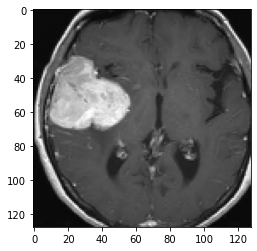

In [14]:
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
img_path = "Data Devided/test/tumor/image(19).jpg"
img = io.imread(img_path)
x =cv2.resize(img,(128, 128))
imgplot = plt.imshow(x)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)[0]
 
if (preds >=0.5):
    print("Tumor")
else :
    print("no tumor")

1/1 [==============================] - 0s 359ms/step
no tumor


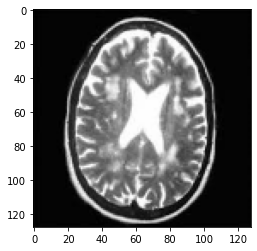

In [15]:
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
img_path = "Data Devided/test/no_tumor/8.jpg"
img = io.imread(img_path)
x =cv2.resize(img,(128, 128))
imgplot = plt.imshow(x)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)[0]
 
if (preds >=0.5):
    print("Tumor")
else :
    print("no tumor")